In [1]:
import numpy as np
from scipy import optimize
from scipy.stats import multivariate_normal, norm
from scipy.integrate import dblquad, tplquad
import matplotlib.pyplot as plt
import itertools

# R1.2: **Single product and stochastic environment**:  BUDGET


In [2]:
def compute_win_probabilities_joint(prices, buyer, num_samples=50000):
    num_products = len(buyer.mu)
    num_prices = len(prices)

    valuations = np.random.multivariate_normal(buyer.mu, buyer.sigma, size=num_samples)
    win_probabilities = np.zeros((num_products, num_prices))

    for j in range(num_products):
        for p_idx, price_j in enumerate(prices):
            count_greater = np.sum(valuations[:, j] > price_j)
            win_probabilities[j, p_idx] = count_greater / num_samples

    return win_probabilities

In [3]:
def compute_best_prices_multi_product(prices, rho, buyer, num_samples=50000):
    """
    Compute optimal pricing per product, with capacity constraints, similar to compute_combinatorial_opt.
    
    Parameters:
    - prices: array of possible prices (length K)
    - rho: maximum expected units sold per product (scalar)
    - buyer: Buyer object with mu and sigma
    - num_samples: for Monte Carlo win prob estimation
    
    Returns:
    - gamma_matrix: N x K array of price distributions (per product)
    - expected_revenue: scalar
    - expected_units_sold: scalar
    """
    prices = np.array(prices)
    K = len(prices)
    N = len(buyer.mu)
    
    win_probs = compute_win_probabilities_joint(prices, buyer, num_samples)
    
    gamma_matrix = np.zeros((N, K))
    expected_revenue = 0
    expected_units_sold = 0
    
    for i in range(N):
        f = win_probs[i] * prices  # expected revenue per price
        c = -f                    # we minimize, so negate
        
        A_ub = [win_probs[i]]     # expected units sold ≤ rho
        b_ub = [rho]
        A_eq = [np.ones(K)]       # sum of probabilities = 1
        b_eq = [1]
        bounds = [(0, 1)] * K
        
        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub,
                               A_eq=A_eq, b_eq=b_eq,
                               bounds=bounds, method='highs')
        
        if res.success:
            gamma = res.x
            gamma_matrix[i] = gamma
            expected_revenue += np.dot(gamma, f)
            expected_units_sold += np.dot(gamma, win_probs[i])
        else:
            raise ValueError(f"LP failed for product {i}: {res.message}")
    
    return gamma_matrix, expected_revenue, expected_units_sold


### BUYER: Users

In [4]:
class Buyer:
  def __init__(self, mu, sigma):
    """
    Buyer using a multivariate normal distribution for valuations.
    :param mu: Mean vector (list or 1D numpy array)
    :param sigma: Covariance matrix (2D numpy array)
    """
    self.mu = np.array(mu)
    self.sigma = np.array(sigma)
    self.dimension = self.mu.shape[0]

    # Validate that the covariance matrix is square and matches the mean vector
    if self.sigma.shape != (self.dimension, self.dimension):
      raise ValueError("Covariance matrix shape must match (len(mu), len(mu))")

  def round(self, prices):
    """
    Simulates a round where the buyer evaluates multiple prices.
    :param prices: List or array of offered prices (must match dimension)
    :return: Binary array indicating purchases (1 = buy, 0 = no buy)
    """
    valuations = np.random.multivariate_normal(self.mu, self.sigma)
    prices = np.array(prices)

    if len(prices) != self.dimension:
      raise ValueError("Length of prices must match length of mean vector")

    return (valuations > prices).astype(int)

## UCB1 V1: Basic Combinatorial Strategy

This version uses a **product-wise decomposition approach** where:

- **Strategy**: Each product is treated independently for optimization
- **UCB Computation**: Upper confidence bounds are calculated separately for each product-price pair
- **Optimization**: Linear programming is solved independently for each product using:
  - Objective: Maximize expected revenue (f_ucbs) for each product
  - Constraint: Expected units sold ≤ ρ (budget constraint per product)
- **Super-arm Selection**: For each product, sample from the optimal probability distribution γ
- **Key Insight**: Decomposes the multi-product problem into N independent single-product subproblems

This approach simplifies the combinatorial complexity but may not capture correlations between products optimally.

In [5]:
class CombinatorialCompanyUCB1_V1:
    def __init__(self, K, B, T, N, range=1):
        self.K = K
        self.T = T
        self.N = N
        self.range = range
        self.s_t = None
        self.avg_f = np.zeros((N, K))
        self.avg_c = np.zeros((N, K))
        self.N_pulls = np.zeros((N, K))
        self.budget = B
        self.rho = B / T
        self.t = 0

    def pull_superarm(self):
        if self.budget < 1:
            self.s_t = np.zeros(self.N, dtype=int)
            return self.s_t
        
        self.s_t = np.zeros(self.N, dtype=int)
        f_ucbs = self.avg_f + self.range * np.sqrt(2 * np.log(self.T) / (self.N_pulls + 1e-8))
        c_lcbs = self.avg_c - self.range * np.sqrt(2 * np.log(self.T) / (self.N_pulls + 1e-8))
        gamma_m = self.compute_combinatorial_opt(f_ucbs, c_lcbs)
        gamma_m[gamma_m < 1e-10] = 0
         
        for i in range(self.N):
            gammp_t = gamma_m[i]
            self.s_t[i] = np.random.choice(self.K, p=gammp_t)
        return self.s_t

    def compute_combinatorial_opt(self, f_ucbs_matrix, c_lcbs_matrix):
        N, K = f_ucbs_matrix.shape
        gamma_matrix = np.zeros((N, K))
        for i in range(N):
            f_ucbs = f_ucbs_matrix[i]
            c_lcbs = c_lcbs_matrix[i]
            if np.all(c_lcbs <= 0):
                gamma = np.zeros(K)
                gamma[np.argmax(f_ucbs)] = 1.0
                gamma_matrix[i] = gamma
                continue
            c = -f_ucbs
            A_ub = [c_lcbs]
            b_ub = [self.rho]
            A_eq = [np.ones(K)]
            b_eq = [1]
            bounds = [(0, 1) for _ in range(K)]
            res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
            if res.success:
                gamma_matrix[i] = res.x
            else:
                raise ValueError(f"LP failed for product {i}: {res.message}")
        return gamma_matrix

    def update(self, f_t, c_t, p_t, n_t):
        self.N_pulls[n_t, p_t] += 1
        self.avg_f[n_t, p_t] += (f_t - self.avg_f[n_t, p_t]) / self.N_pulls[n_t, p_t]
        self.avg_c[n_t, p_t] += (c_t - self.avg_c[n_t, p_t]) / self.N_pulls[n_t, p_t]
        self.budget -= c_t
        self.t += 1

In [6]:
# Experiment setup
T = 10000
B = 16000

P = np.linspace(0, 1, 11)
K = len(P)
N = 3
mu = [0.5, 0.6, 0.7]
sigma = np.array([[0.1, 0.05, 0.02],
                  [0.05, 0.1, 0.03],
                  [0.02, 0.03, 0.1]])

buyer = Buyer(mu=mu, sigma=sigma)
gamma, exp_utility, expected_units_sold = compute_best_prices_multi_product(P, B/T, buyer)

print(f"Gamma: {gamma}")
print(f"Expected utility: {exp_utility}")
print(f"Expected unit sold: {expected_units_sold}")

n_trials = 5
regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    buyer = Buyer(mu, sigma)
    agent = CombinatorialCompanyUCB1_V1(K=K, B=B, T=T, N=N)
    ag_utility = np.zeros(T)

    flag = True
    for t in range(T):
        super_arm = agent.pull_superarm()
        prices = [P[super_arm[n]] for n in range(N)]
        sold = buyer.round(prices)

        for n_t in range(N):
            p_t = super_arm[n_t]
            price = P[p_t]
            is_sold = sold[n_t]

            f_t = price if is_sold else 0
            c_t = 1 if is_sold else 0

            agent.update(f_t=f_t, c_t=c_t, p_t=p_t, n_t=n_t)
            ag_utility[t] += f_t

        #print(f"Trial {seed} {t+1} budget left:", agent.budget)

        if agent.budget <= 0 and flag:
            print("TRIAL", seed+1, "Budget exhausted at round", t)
            flag = False

    cumulative_regret = np.cumsum(exp_utility - ag_utility)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)
average_regret = regret_per_trial.mean(axis=0)
regret_std = regret_per_trial.std(axis=0)

print("Agent Cumulative Reward", np.sum(ag_utility))
print("Average cumulative regret", average_regret[-1])

Gamma: [[ 0.  0.  0.  0. -0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]]
Expected utility: 0.933586
Expected unit sold: 1.74232
TRIAL 1 Budget exhausted at round 9140
TRIAL 2 Budget exhausted at round 9191
TRIAL 3 Budget exhausted at round 9196
TRIAL 4 Budget exhausted at round 9021
TRIAL 5 Budget exhausted at round 9219
Agent Cumulative Reward 7412.099999999999
Average cumulative regret 1986.3400000001034


Time 3min 50sec

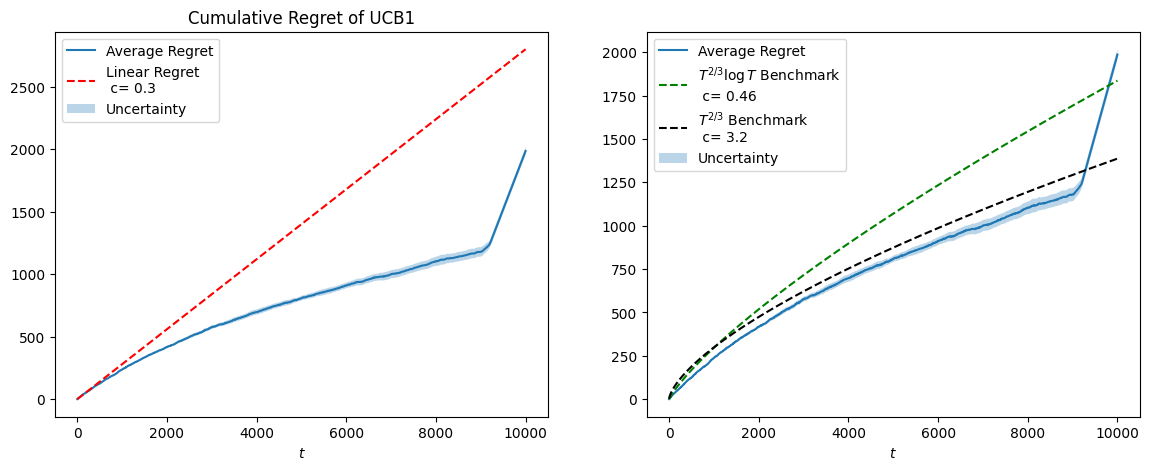

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# First subplot: Cumulative regret with linear line 
axs[0].plot(np.arange(T), average_regret, label='Average Regret')
axs[0].set_title('Cumulative Regret of UCB1')

c_linear = 0.3
linear_regret = np.arange(T) * exp_utility * c_linear
axs[0].plot(np.arange(T), linear_regret, label='Linear Regret' f'\n c= {c_linear}', linestyle='--', color='red')
axs[0].fill_between(
    np.arange(T),
    average_regret - regret_std / np.sqrt(n_trials),
    average_regret + regret_std / np.sqrt(n_trials),
    alpha=0.3,
    label='Uncertainty'
)
axs[0].set_xlabel('$t$')
axs[0].legend()

# Second subplot: T^{2/3} benchmark
axs[1].plot(np.arange(T), average_regret, label='Average Regret')
t_vals = np.arange(1, T+1)
c_log = 0.46
benchmark = (t_vals ** (2/3)) * np.log(t_vals) * exp_utility * c_log
axs[1].plot(np.arange(T), benchmark, label=r'$T^{2/3}\log T$ Benchmark' + f'\n c= {c_log}', linestyle='--', color='green')
c_no_log = 3.2
benchmark = (t_vals ** (2/3)) * exp_utility * c_no_log
axs[1].plot(np.arange(T), benchmark, label=r'$T^{2/3}$ Benchmark'+ f'\n c= {c_no_log}', linestyle='--', color='black')

# Fill between for uncertainty in the second plot
axs[1].fill_between(
    np.arange(T),
    average_regret - regret_std / np.sqrt(n_trials),
    average_regret + regret_std / np.sqrt(n_trials),
    alpha=0.3,
    label='Uncertainty'
)

# Set titles and labels for the second subplot
axs[1].set_xlabel('$t$')
axs[1].legend()

plt.show()

## UCB1 V2: Full Combinatorial Strategy with Linear Programming

This version uses a **complete combinatorial approach** where:

- **Strategy**: Considers all possible super-arms (combinations of prices across all products)
- **Super-arm Space**: All K^N possible combinations where each product can take any of K prices
- **UCB Computation**: Upper confidence bounds calculated for entire super-arms rather than individual product-price pairs
- **Optimization**: Uses linear programming over the full super-arm space:
  - Variables: Probability distribution over all K^N super-arms
  - Objective: Maximize expected revenue across all super-arms
  - Constraint: Expected capacity consumption ≤ ρ (global budget constraint)
- **Key Insight**: Captures the full combinatorial structure and correlations between products

This approach is theoretically optimal but computationally expensive due to the exponential super-arm space (K^N grows quickly).

In [8]:
class CombinatorialCompanyUCB1_V2:
    def __init__(self, K, B, T, N, _range=1):
        self.K = K                  # number of prices
        self.N = N                  # number of products
        self.T = T                  # time horizon
        self.B = B                  # total budget
        self.ucb_range = _range

        self.budget = B
        self.rho = B / T
        self.t = 0

        self.N_pulls = np.zeros((N, K))

        # All possible product-price assignments (cartesian product)
        self.superarms = list(itertools.product(range(K), repeat=N))
        self.num_superarms = len(self.superarms)

        self.avg_f = np.zeros(self.num_superarms)
        self.avg_c = np.zeros(self.num_superarms)

        self.s_t = None

    def pull_superarm(self):
        if self.budget < 1:
            self.s_t = tuple([0] * self.N)
            return self.s_t

        f_ucbs = np.zeros(self.num_superarms)
        c_lcbs = np.zeros(self.num_superarms)
        
        for i, superarm in enumerate(self.superarms):
            pulls = np.array([self.N_pulls[n, p] for n, p in enumerate(superarm)])
            total_pulls = np.sum(pulls)

            f_ucbs[i] = self.avg_f[i] + self.ucb_range * np.sqrt(2 * np.log(self.T) / (total_pulls + 1e-8))
            c_lcbs[i] = self.avg_c[i] - self.ucb_range * np.sqrt(2 * np.log(self.T) / (total_pulls + 1e-8))

        idx = self.compute_opt(f_ucbs, c_lcbs)
        self.s_t = self.superarms[idx]
        return self.s_t

    def compute_opt(self, f_ucbs, c_lcbs):
        feasible = c_lcbs <= self.rho
        if not np.any(feasible):
            return np.argmax(f_ucbs)

        c = -f_ucbs
        bounds = [(0, 1) for _ in range(self.num_superarms)]
        A_ub = [c_lcbs]
        b_ub = [self.rho]
        A_eq = [np.ones(self.num_superarms)]
        b_eq = [1]

        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds)

        if res.success:
            prob_dist = res.x
            prob_dist[prob_dist < 1e-10] = 0
            prob_dist /= prob_dist.sum()
            return np.random.choice(self.num_superarms, p=prob_dist)
        else:
            return np.argmax(f_ucbs)
        
    def update(self, f_t, c_t, superarm):
        for n, p in enumerate(superarm):  # superarm is a tuple like (5, 3, 6)
            self.N_pulls[n, p] += 1

        idx = self.superarms.index(tuple(superarm))
        self.avg_f[idx] += (f_t - self.avg_f[idx]) / np.maximum(1, np.sum(self.N_pulls))  
        self.avg_c[idx] += (c_t - self.avg_c[idx]) / np.maximum(1, np.sum(self.N_pulls))
        
        self.budget -= c_t
        self.t += 1

In [9]:
# Experiment setup
T = 10000
B = 16000
P = np.linspace(0, 1, 11)
K = len(P)
N = 3
mu = [0.5, 0.6, 0.7]
sigma = np.array([[0.1, 0.05, 0.02],
                  [0.05, 0.1, 0.03],
                  [0.02, 0.03, 0.1]])

buyer = Buyer(mu=mu, sigma=sigma)
gamma, exp_utility, expected_units_sold = compute_best_prices_multi_product(P, B/T, buyer)

print(f"Gamma: {gamma}")
print(f"Expected utility: {exp_utility}")
print(f"Expected unit sold: {expected_units_sold}")

n_trials = 5
regret_per_trial = []

for seed in range(n_trials):

    print("Trial", seed)
    
    np.random.seed(seed)
    buyer = Buyer(mu, sigma)
    agent = CombinatorialCompanyUCB1_V2(K=K, B=B, T=T, N=N)
    ag_utility = np.zeros(T)

    flag = True
    for t in range(T):
        super_arm = agent.pull_superarm()
        prices = [P[super_arm[n]] for n in range(N)]
        sold = buyer.round(prices)

        for n_t in range(N):
            p_t = super_arm[n_t]
            price = P[p_t]
            is_sold = sold[n_t]

            f_t = price if is_sold else 0
            c_t = 1 if is_sold else 0

            ag_utility[t] += f_t

            agent.update(f_t=f_t, c_t=c_t, superarm=super_arm)

        if t % 100 == 0:
            print(f"Trial {seed+1} at {t+1} budget left:", agent.budget)

        if agent.budget <= 0 and flag:
            print("TRIAL", seed, "Budget exhausted at round", t)
            flag = False

    cumulative_regret = np.cumsum(exp_utility - ag_utility)
    regret_per_trial.append(cumulative_regret)
    print(f"Trial {seed} budget left:", agent.budget)

regret_per_trial = np.array(regret_per_trial)
average_regret = regret_per_trial.mean(axis=0)
regret_std = regret_per_trial.std(axis=0)

print("Agent Cumulative Reward", np.sum(ag_utility))
print("Average cumulative regret", average_regret[-1])

Gamma: [[ 0.  0.  0.  0. -0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]]
Expected utility: 0.9414760000000002
Expected unit sold: 1.75706
Trial 0
Trial 1 at 1 budget left: 15997
Trial 1 at 101 budget left: 15812
Trial 1 at 201 budget left: 15625
Trial 1 at 301 budget left: 15469


KeyboardInterrupt: 

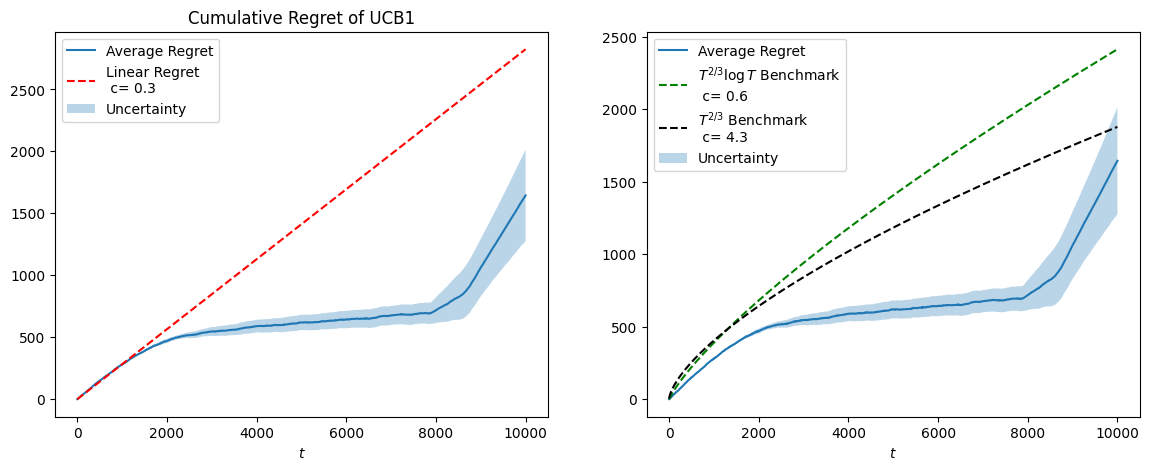

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# First subplot: Cumulative regret with linear line 
axs[0].plot(np.arange(T), average_regret, label='Average Regret')
axs[0].set_title('Cumulative Regret of UCB1')

c_linear = 0.3
linear_regret = np.arange(T) * exp_utility * c_linear
axs[0].plot(np.arange(T), linear_regret, label='Linear Regret' f'\n c= {c_linear}', linestyle='--', color='red')
axs[0].fill_between(
    np.arange(T),
    average_regret - regret_std / np.sqrt(n_trials),
    average_regret + regret_std / np.sqrt(n_trials),
    alpha=0.3,
    label='Uncertainty'
)
axs[0].set_xlabel('$t$')
axs[0].legend()

# Second subplot: T^{2/3} benchmark
axs[1].plot(np.arange(T), average_regret, label='Average Regret')
t_vals = np.arange(1, T+1)
c_log = 0.6
benchmark = (t_vals ** (2/3)) * np.log(t_vals) * exp_utility * c_log
axs[1].plot(np.arange(T), benchmark, label=r'$T^{2/3}\log T$ Benchmark' + f'\n c= {c_log}', linestyle='--', color='green')
c_no_log = 4.3
benchmark = (t_vals ** (2/3)) * exp_utility * c_no_log
axs[1].plot(np.arange(T), benchmark, label=r'$T^{2/3}$ Benchmark'+ f'\n c= {c_no_log}', linestyle='--', color='black')

# Fill between for uncertainty in the second plot
axs[1].fill_between(
    np.arange(T),
    average_regret - regret_std / np.sqrt(n_trials),
    average_regret + regret_std / np.sqrt(n_trials),
    alpha=0.3,
    label='Uncertainty'
)

# Set titles and labels for the second subplot
axs[1].set_xlabel('$t$')
axs[1].legend()

plt.show()

## UCB1 V3: Greedy Combinatorial Strategy

This version uses a **simplified greedy approach** where:

- **Strategy**: Combines the super-arm enumeration of V2 with a greedy selection mechanism
- **Super-arm Space**: Still considers all K^N possible super-arms like V2
- **UCB Computation**: Same as V2 - upper confidence bounds for entire super-arms
- **Optimization**: **Greedy selection instead of linear programming**:
  - Filter super-arms by feasibility (capacity constraint c_lcb ≤ ρ)
  - Among feasible super-arms, greedily select the one with highest expected revenue (f_ucb)
  - If no feasible super-arms exist, select the one with highest revenue regardless
- **Key Insight**: Trades off optimality for computational efficiency while maintaining the full combinatorial structure

This approach reduces computational complexity compared to V2 while still considering all super-arm combinations, but may be suboptimal due to the greedy selection.

In [ ]:
class CombinatorialCompanyUCB1_V3:
    def __init__(self, K, B, T, N, _range=1):
        self.K = K                  # number of prices
        self.N = N                  # number of products
        self.T = T                  # time horizon
        self.B = B                  # total budget
        self.ucb_range = _range

        self.budget = B
        self.rho = B / T
        self.t = 0

        self.N_pulls = np.zeros((N, K))

        # All possible product-price assignments (cartesian product)
        self.superarms = list(itertools.product(range(K), repeat=N))
        self.num_superarms = len(self.superarms)

        self.avg_f = np.zeros(self.num_superarms)
        self.avg_c = np.zeros(self.num_superarms)

        self.s_t = None

    def pull_superarm(self):
        if self.budget < 1:
            self.s_t = tuple([0] * self.N)
            return self.s_t

        f_ucbs = np.zeros(self.num_superarms)
        c_lcbs = np.zeros(self.num_superarms)
        
        for i, superarm in enumerate(self.superarms):
            pulls = np.array([self.N_pulls[n, p] for n, p in enumerate(superarm)])
            total_pulls = np.sum(pulls)

            f_ucbs[i] = self.avg_f[i] + self.ucb_range * np.sqrt(2 * np.log(self.T) / (total_pulls + 1e-8))
            c_lcbs[i] = self.avg_c[i] - self.ucb_range * np.sqrt(2 * np.log(self.T) / (total_pulls + 1e-8))

        idx = self.compute_opt(f_ucbs, c_lcbs)
        self.s_t = self.superarms[idx]
        return self.s_t

    def compute_opt(self, f_ucbs, c_lcbs):
        # dont use the linear program solver, just use a greedy approach
        feasible = c_lcbs <= self.rho
        if not np.any(feasible):
            return np.argmax(f_ucbs)
        return np.argmax(f_ucbs[feasible])
        
    def update(self, f_t, c_t, superarm):
        for n, p in enumerate(superarm):  # superarm is a tuple like (5, 3, 6)
            self.N_pulls[n, p] += 1

        idx = self.superarms.index(tuple(superarm))
        self.avg_f[idx] += (f_t - self.avg_f[idx]) / np.maximum(1, np.sum(self.N_pulls))  
        self.avg_c[idx] += (c_t - self.avg_c[idx]) / np.maximum(1, np.sum(self.N_pulls))
        
        self.budget -= c_t
        self.t += 1

In [ ]:
# Experiment setup
T = 10000
B = 16000
P = np.linspace(0, 1, 11)
K = len(P)
N = 3
mu = [0.5, 0.6, 0.7]
sigma = np.array([[0.1, 0.05, 0.02],
                  [0.05, 0.1, 0.03],
                  [0.02, 0.03, 0.1]])

buyer = Buyer(mu=mu, sigma=sigma)
gamma, exp_utility, expected_units_sold = compute_best_prices_multi_product(P, B/T, buyer)

print(f"Gamma: {gamma}")
print(f"Expected utility: {exp_utility}")
print(f"Expected unit sold: {expected_units_sold}")

n_trials = 5
regret_per_trial = []

for seed in range(n_trials):

    print("Trial", seed)
    
    np.random.seed(seed)
    buyer = Buyer(mu, sigma)
    agent = CombinatorialCompanyUCB1_V3(K=K, B=B, T=T, N=N)
    ag_utility = np.zeros(T)

    flag = True
    for t in range(T):
        super_arm = agent.pull_superarm()
        prices = [P[super_arm[n]] for n in range(N)]
        sold = buyer.round(prices)

        for n_t in range(N):
            p_t = super_arm[n_t]
            price = P[p_t]
            is_sold = sold[n_t]

            f_t = price if is_sold else 0
            c_t = 1 if is_sold else 0

            ag_utility[t] += f_t

            agent.update(f_t=f_t, c_t=c_t, superarm=super_arm)

        if t % 100 == 0:
            print(f"Trial {seed+1} at {t+1} budget left:", agent.budget)

        if agent.budget <= 0 and flag:
            print("TRIAL", seed, "Budget exhausted at round", t)
            flag = False

    cumulative_regret = np.cumsum(exp_utility - ag_utility)
    regret_per_trial.append(cumulative_regret)
    print(f"Trial {seed} budget left:", agent.budget)

regret_per_trial = np.array(regret_per_trial)
average_regret = regret_per_trial.mean(axis=0)
regret_std = regret_per_trial.std(axis=0)

print("Agent Cumulative Reward", np.sum(ag_utility))
print("Average cumulative regret", average_regret[-1])

Gamma: [[ 0.  0.  0.  0.  1. -0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]]
Expected utility: 0.9392840000000001
Expected unit sold: 1.8782
Trial 0
Trial 1 at 1 budget left: 15998
Trial 1 at 101 budget left: 15826
Trial 1 at 201 budget left: 15647
Trial 1 at 301 budget left: 15473
Trial 1 at 401 budget left: 15307
Trial 1 at 501 budget left: 15132
Trial 1 at 601 budget left: 14964
Trial 1 at 701 budget left: 14792
Trial 1 at 801 budget left: 14614
Trial 1 at 901 budget left: 14443
Trial 1 at 1001 budget left: 14262
Trial 1 at 1101 budget left: 14091
Trial 1 at 1201 budget left: 13915
Trial 1 at 1301 budget left: 13743
Trial 1 at 1401 budget left: 13566
Trial 1 at 1501 budget left: 13397
Trial 1 at 1601 budget left: 13214
Trial 1 at 1701 budget left: 13049
Trial 1 at 1801 budget left: 12853
Trial 1 at 1901 budget left: 12672
Trial 1 at 2001 budget left: 12500
Trial 1 at 2101 budget left: 12320
Trial 1 at 2201 budge

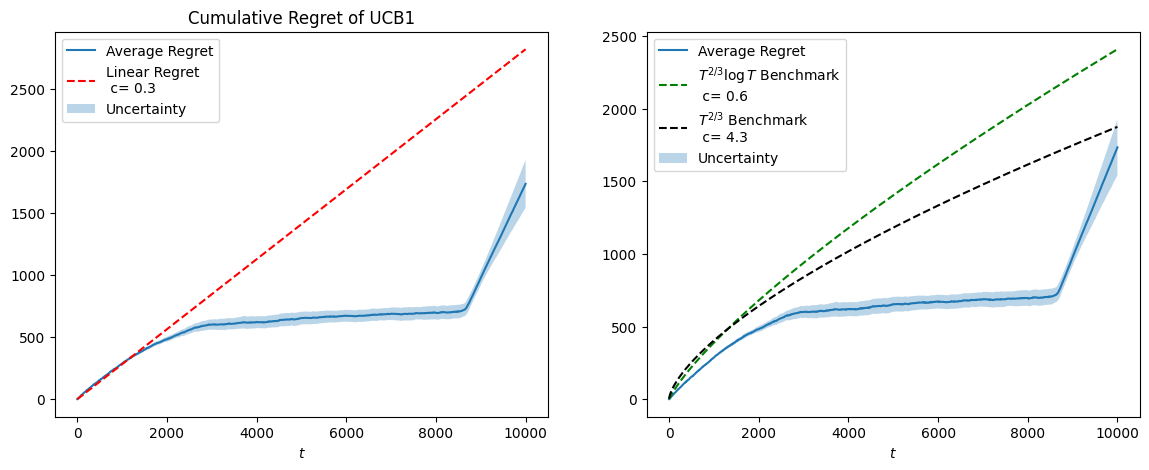

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# First subplot: Cumulative regret with linear line 
axs[0].plot(np.arange(T), average_regret, label='Average Regret')
axs[0].set_title('Cumulative Regret of UCB1')

c_linear = 0.3
linear_regret = np.arange(T) * exp_utility * c_linear
axs[0].plot(np.arange(T), linear_regret, label='Linear Regret' f'\n c= {c_linear}', linestyle='--', color='red')
axs[0].fill_between(
    np.arange(T),
    average_regret - regret_std / np.sqrt(n_trials),
    average_regret + regret_std / np.sqrt(n_trials),
    alpha=0.3,
    label='Uncertainty'
)
axs[0].set_xlabel('$t$')
axs[0].legend()

# Second subplot: T^{2/3} benchmark
axs[1].plot(np.arange(T), average_regret, label='Average Regret')
t_vals = np.arange(1, T+1)
c_log = 0.6
benchmark = (t_vals ** (2/3)) * np.log(t_vals) * exp_utility * c_log
axs[1].plot(np.arange(T), benchmark, label=r'$T^{2/3}\log T$ Benchmark' + f'\n c= {c_log}', linestyle='--', color='green')
c_no_log = 4.3
benchmark = (t_vals ** (2/3)) * exp_utility * c_no_log
axs[1].plot(np.arange(T), benchmark, label=r'$T^{2/3}$ Benchmark'+ f'\n c= {c_no_log}', linestyle='--', color='black')

# Fill between for uncertainty in the second plot
axs[1].fill_between(
    np.arange(T),
    average_regret - regret_std / np.sqrt(n_trials),
    average_regret + regret_std / np.sqrt(n_trials),
    alpha=0.3,
    label='Uncertainty'
)

# Set titles and labels for the second subplot
axs[1].set_xlabel('$t$')
axs[1].legend()

plt.show()